Found 6500 files belonging to 4 classes.
Found 724 files belonging to 4 classes.


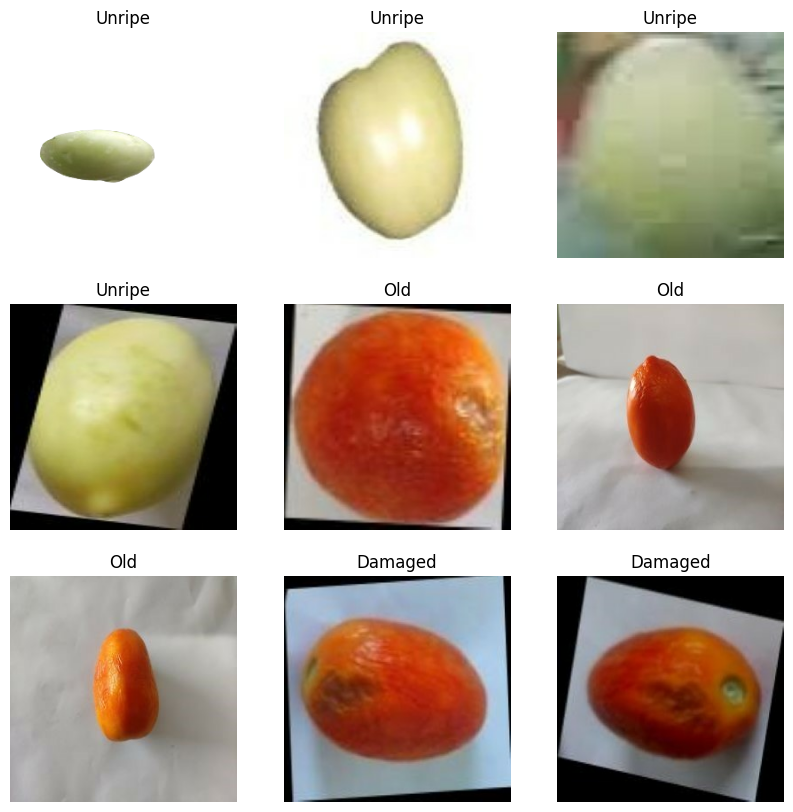

In [57]:
import tensorflow as tf
import matplotlib.pyplot as plt


# Load dataset
train_dir = 'content/ieee-mbl-cls/train'
validation_dir = 'content/ieee-mbl-cls/val'

BATCH_SIZE = 32
IMG_SIZE = (256, 256)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [58]:
# Creating test set 
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

# Performance configurations
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Number of validation batches: 19
Number of test batches: 4


2025-05-03 14:22:27.605014: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


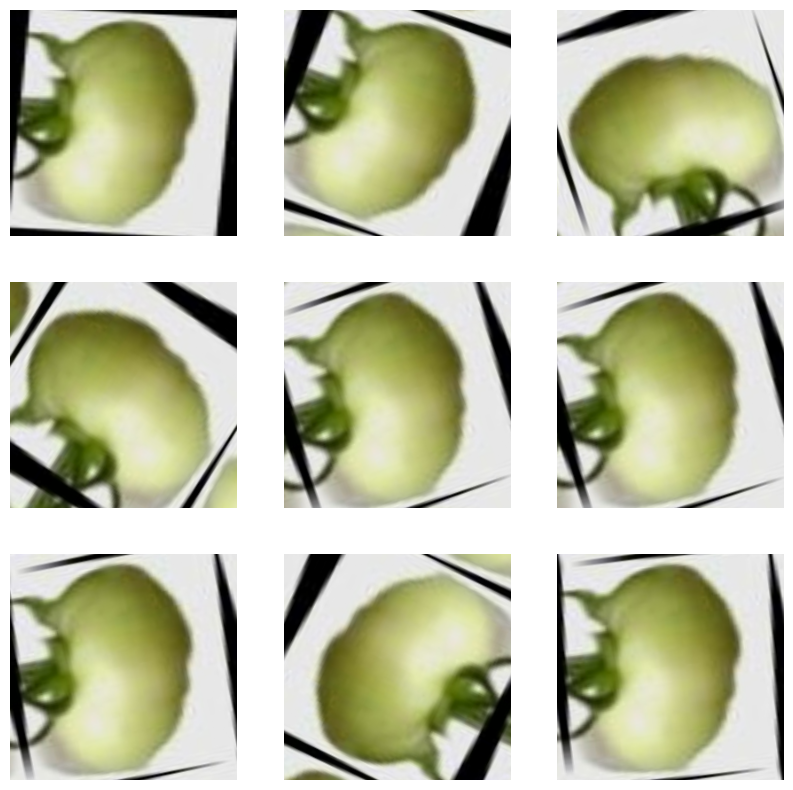

In [59]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [60]:
# Load and set up base model
from tensorflow.keras.applications import efficientnet_v2
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input
from tensorflow.keras import layers, models, optimizers

# Load with pre-trained weights
base_model = efficientnet_v2.EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

# Build full model
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(4, activation='softmax')(x)  # 4-class output

model = models.Model(inputs, outputs)

model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_11 (Sequential)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 8, 8, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,083,796 (23.21 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 296ms/step - accuracy: 0.2559 - loss: 1.3939
initial loss: 1.39
initial accuracy: 0.27
Epoch 1/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 67s 309ms/step - accuracy: 0.6028 - loss: 0.9466 - val_accuracy: 0.8826 - val_loss: 0.3744
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 64s 311ms/step - accuracy: 0.8707 - loss: 0.3889 - val_accuracy: 0.9144 - val_loss: 0.2474
Epoch 3/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 66s 325ms/step - accuracy: 0.9027 - loss: 0.2797 - val_accuracy: 0.9228 - val_loss: 0.2319
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 67s 329ms/step - accuracy: 0.9052 - loss: 0.2524 - val_accuracy: 0.9446 - val_loss: 0.1974
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 64s 314ms/step - accuracy: 0.9185 - loss: 0.2271 - val_accuracy: 0.9480 - val_loss: 0.1674
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 64s 314ms/step - accuracy: 0.9230 - loss: 0.2165 - val_accuracy: 0.9564 - val_loss: 0.1556
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 63s 308ms/step - accuracy: 0.9277 - loss: 0.2021 - val_ac

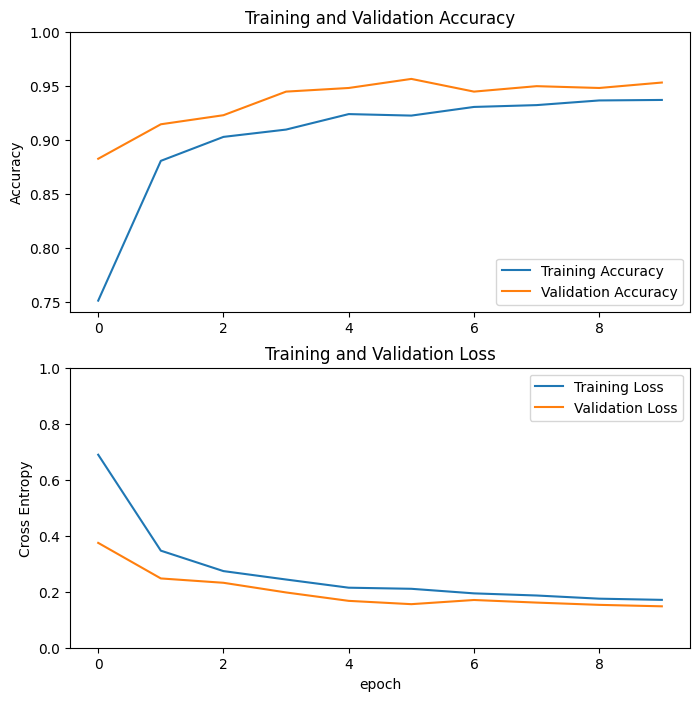

In [61]:
# Compile and train
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=initial_epochs  # Start with 10, increase if needed
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

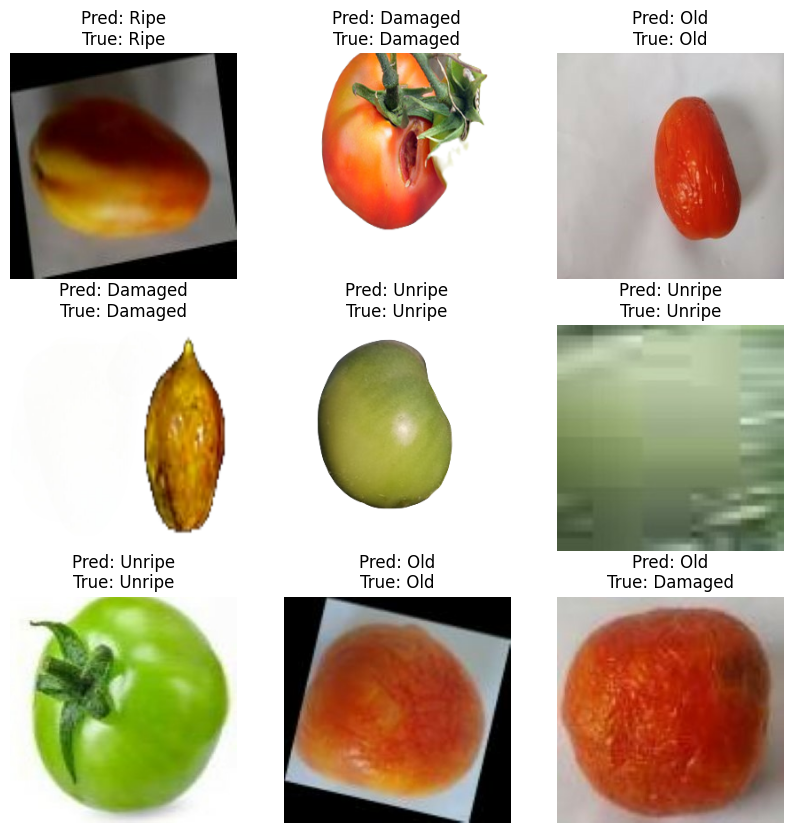

In [62]:
# Test validation

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
# Predict on batch
pred_probs = model.predict_on_batch(image_batch)  # shape: (batch_size, 4)
pred_class_indices = tf.argmax(pred_probs, axis=1).numpy()  # get most probable class

# Display predictions vs ground truth
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    pred_label = class_names[pred_class_indices[i]]
    true_label = class_names[label_batch[i]]
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
    plt.axis("off")


In [63]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input
from tensorflow.keras import Input, layers, models

# Load base model again
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

# Define clean model for export
inputs = Input(shape=(256, 256, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)  # no dropout
outputs = layers.Dense(4, activation='softmax')(x)
inference_model = models.Model(inputs, outputs)
inference_model.set_weights(model.get_weights())


In [64]:
# Save model
inference_model.export("../models/tomato_ripeness_model")

INFO:tensorflow:Assets written to: ../models/tomato_ripeness_model/assets


INFO:tensorflow:Assets written to: ../models/tomato_ripeness_model/assets


Saved artifact at '../models/tomato_ripeness_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_2784')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  16575489296: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  16575486800: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  5493799056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16575492752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16575493520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16575488144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16575493136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16575494480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16575494096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16575495440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16575494672: Tens

In [66]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
tflite_model = converter.convert()

# Save to file
with open("../models/tomato_ripeness_model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/72/p5pcb_114q725f21jd_ng6cr0000gn/T/tmp15sby0ig/assets


INFO:tensorflow:Assets written to: /var/folders/72/p5pcb_114q725f21jd_ng6cr0000gn/T/tmp15sby0ig/assets


Saved artifact at '/var/folders/72/p5pcb_114q725f21jd_ng6cr0000gn/T/tmp15sby0ig'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_2784')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  16575489296: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  16575486800: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  5493799056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16575492752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16575493520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16575488144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16575493136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16575494480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16575494096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16575495440: TensorSpec(shape=(), dtype=tf.resource, n

W0000 00:00:1746308276.232553 109984860 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1746308276.232571 109984860 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-05-03 14:37:56.232745: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/72/p5pcb_114q725f21jd_ng6cr0000gn/T/tmp15sby0ig
2025-05-03 14:37:56.243357: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-05-03 14:37:56.243375: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/72/p5pcb_114q725f21jd_ng6cr0000gn/T/tmp15sby0ig
2025-05-03 14:37:56.382043: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-05-03 14:37:57.084857: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/72/p5pcb_114q725f21jd_ng6cr0000gn/T/tmp15sby0ig
2025-05-03 14:37:57.307955: I tensorflow/cc/saved_model/loader